# Prediction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import arviz as az

plt.rcParams['figure.dpi'] = 75

In [3]:
def plot_prior(trace, **options):
    return pm.plot_posterior(trace, group='prior', **options);

In [4]:
def plot_posterior_predictive(trace, **options):
    return pm.plot_posterior(trace, group='posterior_predictive', **options);

In [5]:
def run_samplers(model, *args, **options):
    with model:
        # Sample the prior predictive
        prior_pred = pm.sample_prior_predictive()

        # Sample from the posterior
        trace = pm.sample(*args, **options)

        # Sample from the posterior predictive
        posterior_pred = pm.sample_posterior_predictive(trace)

    trace.extend(prior_pred)
    trace.extend(posterior_pred)
    
    return trace

# Hierarchical Models

## Section

Here's the data from the A/B tests in the previous notebook.

In [ ]:
A = dict(n=100, k=8)

In [ ]:
B = dict(n=50, k=6)

And here's a version of the model that estimates conversion rates for A and B.

In [ ]:
with pm.Model() as model_AB:
    # Priors for conversion rates of A and B
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha=2, beta=5)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha=2, beta=5)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])

    # Compute the difference in conversion rates
    delta = pm.Deterministic("delta", conversion_rate_B - conversion_rate_A)

Let's run the samplers.

In [ ]:
trace_AB = run_samplers(model_AB)

Sampling: [conversion_rate_A, conversion_rate_B, obs_A, obs_B]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs_A, obs_B]


Output()

As a reminder, here are the priors.

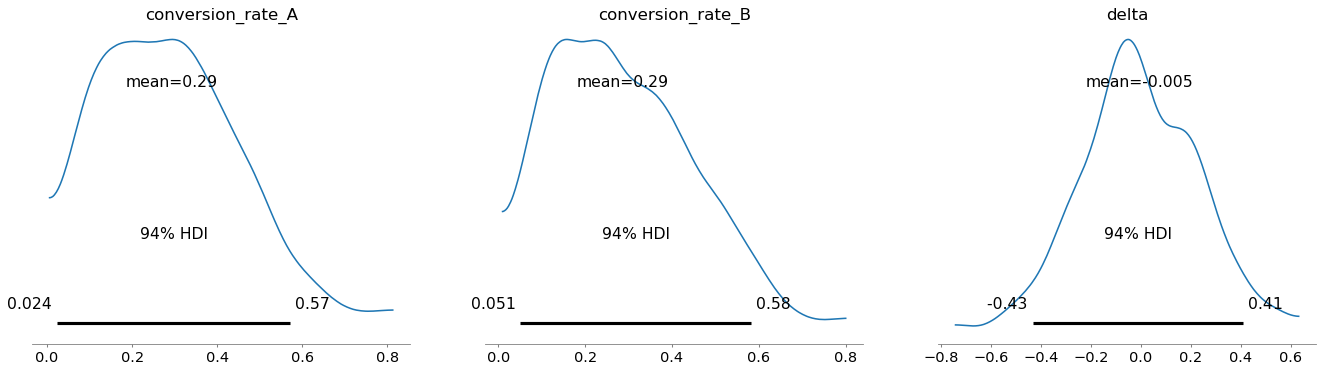

In [ ]:
plot_prior(trace_AB);

And here are the results.

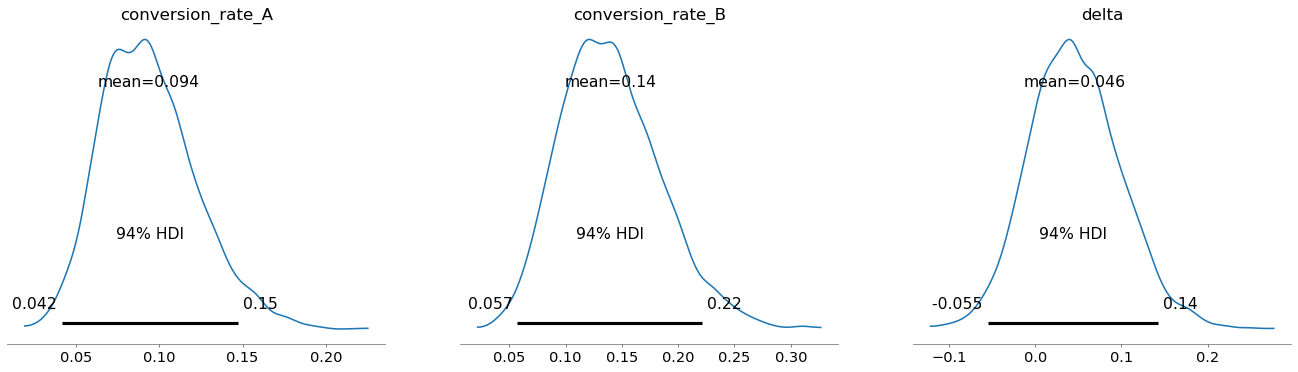

In [ ]:
pm.plot_posterior(trace_AB);

In this model, the conversion rates are independent -- the data from A doesn't affect the posterior distribution for B, and vice versa.

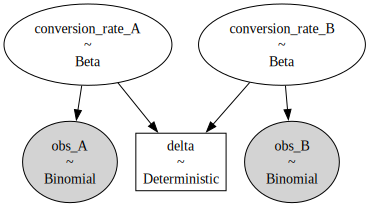

In [ ]:
pm.model_to_graphviz(model_AB)

And that means we are leaving information on the table: because A and B are similar, what we learn about A gives us information about the effectiveness of campaigns like this in general, which influences what we should believe about B.

We take take advantage of this additional information by making the model hierarchical.

In [ ]:
# Modify this

with pm.Model() as hierarchical_AB:
    # Priors for conversion rates of A and B
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha=2, beta=5)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha=2, beta=5)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])

    # Compute the difference in conversion rates
    delta = pm.Deterministic("delta", conversion_rate_B - conversion_rate_A)

In [ ]:
# Solution

with pm.Model() as hierarchical_AB:
    # Hyperpriors for the Beta distributions of A and B
    alpha = pm.Gamma("alpha", 1.0, 0.5)  # Hyperprior for the shape parameter
    beta = pm.Gamma("beta", 2.5, 0.5)    # Hyperprior for the scale parameter
    
    # Priors for conversion rates of A and B, sharing hyperparameters
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha, beta)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha, beta)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])

    # Compute the difference in conversion rates
    delta = pm.Deterministic("delta", conversion_rate_B - conversion_rate_A)

Now when we sample, we simultaneously update beliefs about the conversion rates *and* the hyperpriors.

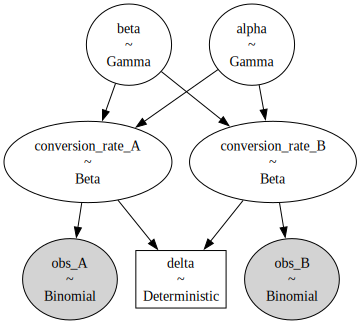

In [ ]:
pm.model_to_graphviz(hierarchical_AB)

In [ ]:
trace = run_samplers(hierarchical_AB)

Sampling: [alpha, beta, conversion_rate_A, conversion_rate_B, obs_A, obs_B]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs_A, obs_B]


Output()

Let's see what the priors looks like.

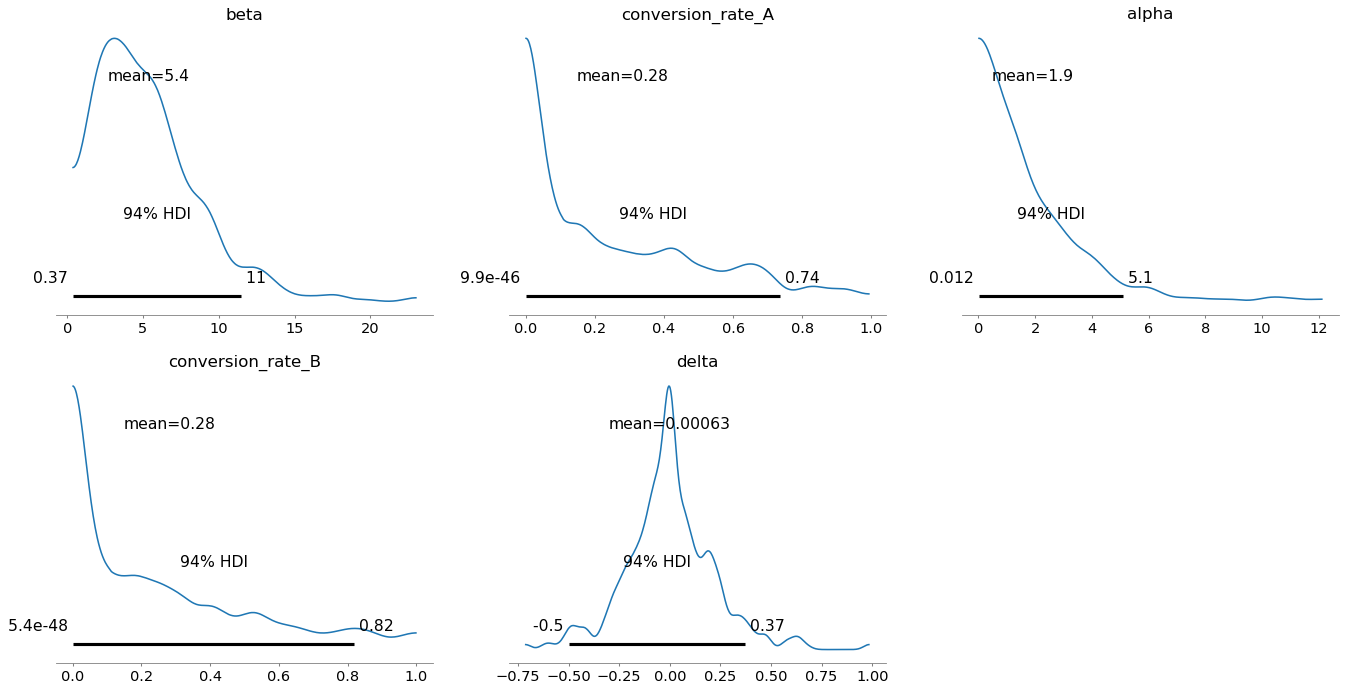

In [ ]:
plot_prior(trace);

And here are the posteriors.

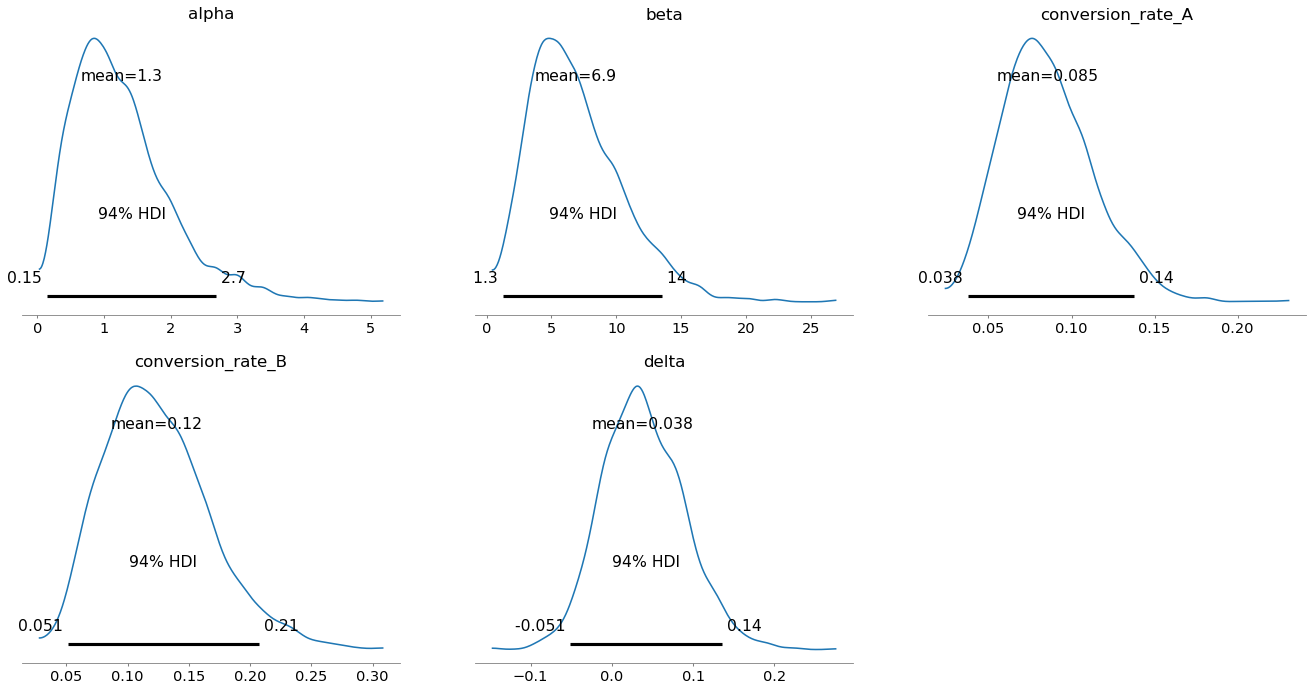

In [ ]:
pm.plot_posterior(trace);

The posterior distributions of `alpha` and `beta` represent what we learned about campaigns in general, based on the results from A and B.
Here's how we can see the implied posterior for the conversion rate of a new, untested campaign.

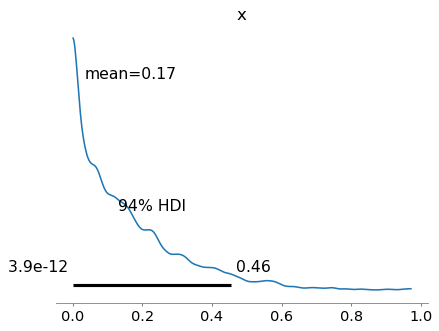

In [ ]:
# Extract posterior samples of alpha and beta
posterior_samples = az.extract(trace)
alpha_samples = posterior_samples["alpha"].values
beta_samples = posterior_samples["beta"].values

# Define the posterior predictive distribution of conversion rates
conversion_rate_dist = pm.Beta.dist(alpha_samples, beta_samples)
sample = pm.draw(conversion_rate_dist)

pm.plot_posterior(sample);

## Section


In [6]:
A = dict(n=100, k=8)


# In[4]:


with pm.Model() as model_A:
    conversion_rate = pm.Beta("conversion_rate", 2, 5)
    obs = pm.Binomial("obs", p=conversion_rate, n=A["n"], observed=A["k"])
    delta = pm.Deterministic("delta", conversion_rate - 0.08)  # just for visual reference


# In[5]:


trace = run_samplers(model_A)


Sampling: [conversion_rate, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Output()

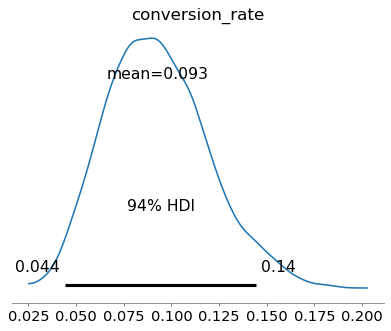

In [9]:
az.plot_posterior(trace, var_names=["conversion_rate"]);

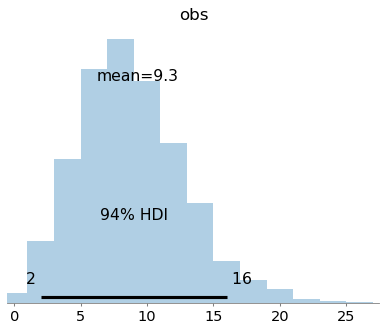

In [10]:
plot_posterior_predictive(trace, var_names=["obs"]);

In [ ]:
## Prediction

Why not just use the mean of the posterior distribution?

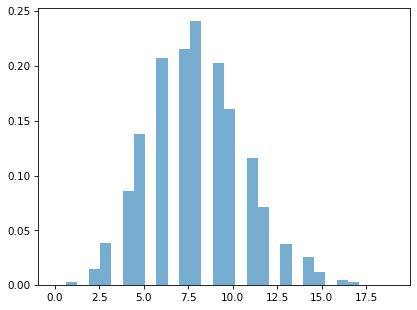

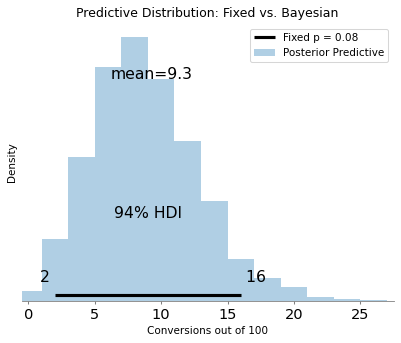

In [11]:
np.random.seed(1)
samples_fixed = np.random.binomial(n=100, p=0.08, size=10_000)




plt.hist(samples_fixed, bins=30, alpha=0.6, label="Fixed p = 0.08", density=True)
plot_posterior_predictive(trace, var_names=["obs"]).legend(["Fixed p = 0.08", "Posterior Predictive"]);
plt.xlabel("Conversions out of 100")
plt.ylabel("Density")
plt.title("Predictive Distribution: Fixed vs. Bayesian");

In [12]:
posterior_samples = az.extract(trace)["conversion_rate"].values
p_5_failures_samples = (1 - posterior_samples) ** 5
p_5_failures_bayesian = np.mean(p_5_failures_samples)
p_5_failures_bayesian


0.6195118672399433

In [ ]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Define independent Beta distributions for each failure step
p_vuln = pm.Beta.dist(alpha=2, beta=18)
p_patch = pm.Beta.dist(alpha=1.5, beta=18)
p_detect = pm.Beta.dist(alpha=1.2, beta=20)
p_phish = pm.Beta.dist(alpha=2, beta=38)
p_access = pm.Beta.dist(alpha=1.5, beta=28)

# Sample from each
n = 1000
samples_vuln = pm.draw(p_vuln, draws=n, random_seed=rng)
samples_patch = pm.draw(p_patch, draws=n, random_seed=rng)
samples_detect = pm.draw(p_detect, draws=n, random_seed=rng)
samples_phish = pm.draw(p_phish, draws=n, random_seed=rng)
samples_access = pm.draw(p_access, draws=n, random_seed=rng)

# Compute breach probability (joint failure)
samples_breach = (
    samples_vuln
    * samples_patch
    * samples_detect
    * samples_phish
    * samples_access
)

# Plot the posterior predictive distribution of breach probabilities
az.plot_posterior(samples_breach, point_estimate="mean", hdi_prob=0.95)
plt.title("Posterior Predictive Distribution: P(Breach)")
plt.xlabel("P(breach)")
plt.show()

<bound method _tensor_py_operators.mean of beta_rv{"(),()->()"}.out>

In [20]:
# Optional: compare to fixed mean probabilities
means = [
    p.mean for p in [p_vuln, p_patch, p_detect, p_phish, p_access]
]
p_fixed = np.prod(means)
print(f"Estimated P(breach) with uncertain probabilities (mean): {samples_breach.mean():.5f}")
print(f"P(breach) with fixed mean probabilities: {p_fixed:.5f}")

TypeError: unsupported operand type(s) for *: 'method' and 'method'

In [16]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_vuln,0.100,0.065,0.005,0.219,0.0,0.0,34002.0,20755.0,1.0
p_patch,0.076,0.059,0.000,0.182,0.0,0.0,31658.0,18115.0,1.0
p_detect,0.057,0.049,0.000,0.146,0.0,0.0,32656.0,18964.0,1.0
p_phish,0.050,0.034,0.001,0.112,0.0,0.0,36696.0,22151.0,1.0
p_access,0.051,0.040,0.000,0.123,0.0,0.0,31782.0,18927.0,1.0
p_breach,0.000,0.000,0.000,0.000,0.0,0.0,25745.0,24121.0,1.0
